# Verkoopprijzen van huizen voorspellen

Team: JaJeTiMa

Urclades -> Jassar Hasiba

Jesse Coenraad

Maaike Jansen

tizianovdzwet - > Tiziano van der Zwet

test

test 2

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
import random



from tensorflow.keras import regularizers
import folium
from PIL import Image
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from google.colab import drive

drive.mount('/content/drive')


In [ ]:
inputPath = "/content/drive/MyDrive/deep_learning_1"

## 1 EDA

### 1.1 Loading in the data

In [ ]:
test_data = pd.read_csv(inputPath + '/test.csv')
test_data

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228
5,506,3,2.0,1471,33.8085,-117.9228
6,507,3,2.0,1248,33.8085,-117.9228
7,508,3,1.5,1214,33.8085,-117.9228
8,509,4,3.0,1882,33.8085,-117.9228
9,510,2,2.5,987,33.8085,-117.9228


In [ ]:
train_data = pd.read_csv(inputPath + '/train.csv')
train_data

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226
...,...,...,...,...,...,...,...
495,496,2,2.0,1257,35.6406,-120.7003,380000
496,497,4,2.0,2072,35.6406,-120.7003,429900
497,498,2,2.0,2213,35.6406,-120.7003,585000
498,499,3,2.5,1500,35.6406,-120.7003,319000


0    1
1    2
2    3
3    4
4    5
Name: House ID, dtype: int64

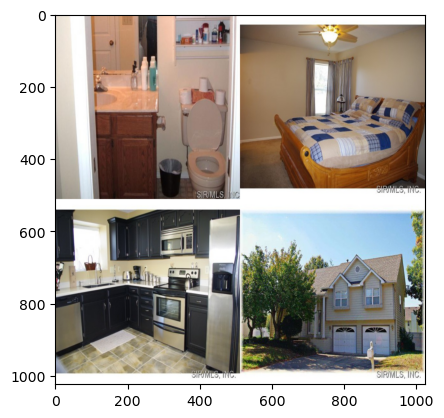

In [ ]:
# Load the labels using pandas
labels = train_data['House ID']

# show the first five rows of the dataframe using head
display(labels.head(5))

def get_image(row_id, root=inputPath + "/Train/"):
    """
    Converts an image number into the file path where the image is located,
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

plt.imshow(get_image(labels.index[random.randint(1, 501)]))
plt.show()

### 1.2 Exploring the data

In [ ]:
display(train_data.describe())
display(train_data.info())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


None

### 1.3 Distribution of variables

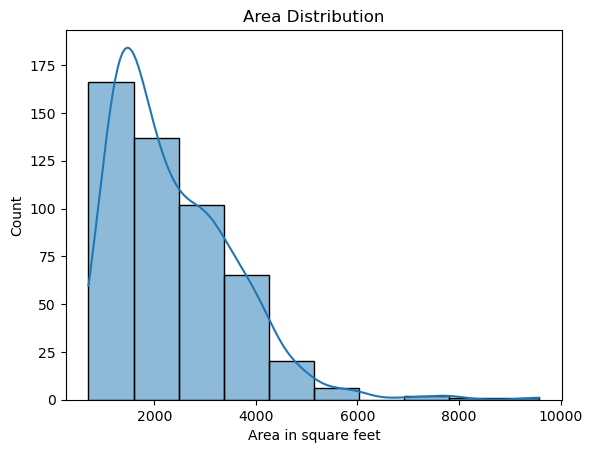

In [ ]:
sns.histplot(train_data['Area'], bins=10, kde=True)
plt.title('Area Distribution')
plt.xlabel('Area in square feet')
plt.show()

It is a right-skewed graph. It can be seen that as the area increases, there are fewer houses.

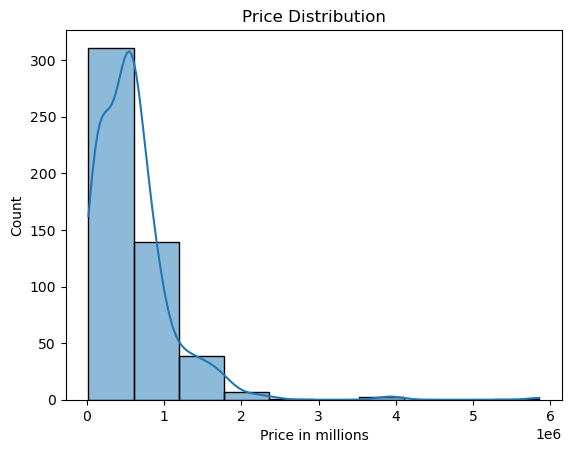

In [ ]:
sns.histplot(train_data['Price'], bins=10, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price in millions')
plt.show()


It is a right-skewed graph. It can be seen that as the price increases, there are fewer houses.

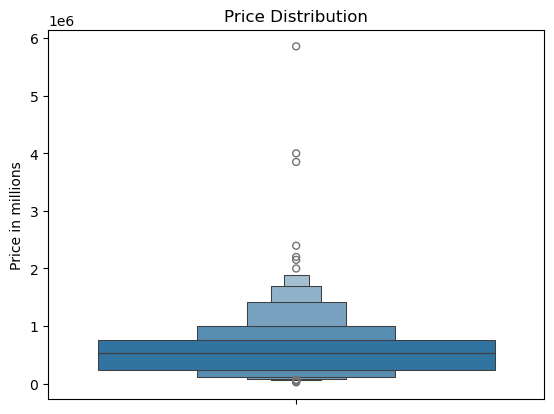

In [ ]:
sns.boxenplot(train_data['Price'])
plt.title('Price Distribution')
plt.ylabel('Price in millions')
plt.show()

There are several outliers in the 'price' column. It can be seen above that some houses are significantly more expensive than the average. Nothing needs to be done about this, as it will have a positive impact on predicting the price of more expensive homes.

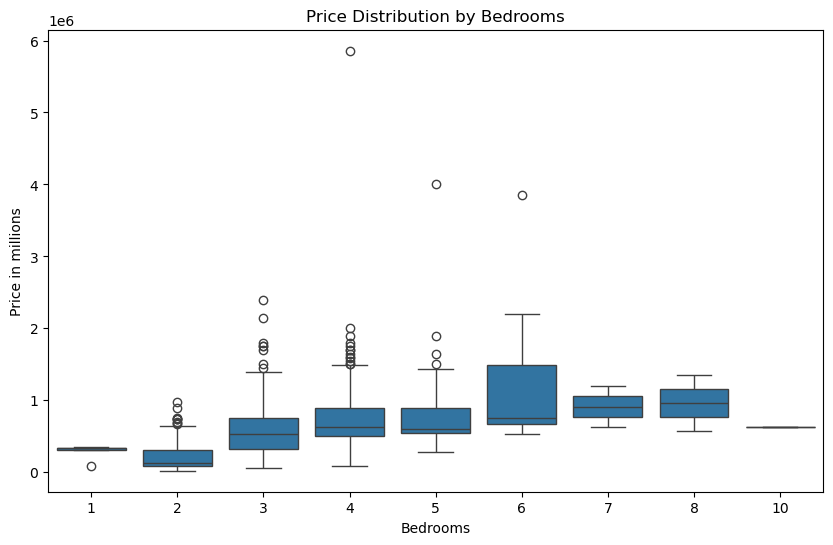

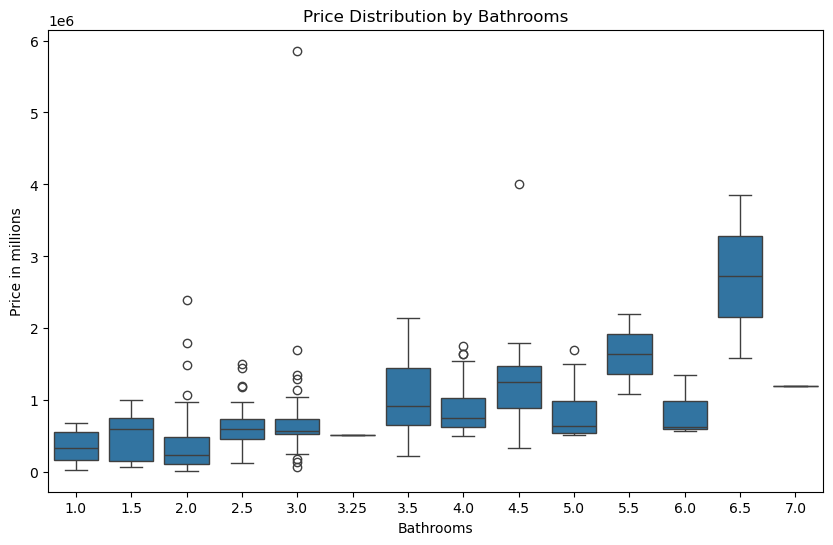

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bedrooms', y='Price', data=train_data)
plt.title('Price Distribution by Bedrooms')
plt.ylabel('Price in millions')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Bathrooms', y='Price', data=train_data)
plt.title('Price Distribution by Bathrooms')
plt.ylabel('Price in millions')
plt.show()

In the graphs above, it can be seen that there is an upward trend in house prices relative to the number of bedrooms and bathrooms per home. This means that the number of bedrooms and bathrooms has a positive correlation with the price of a house.



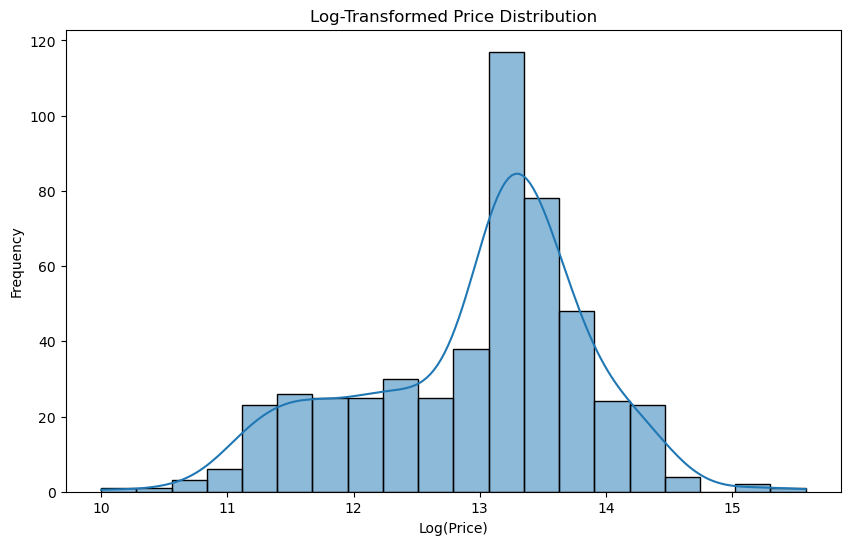

In [ ]:
train_data['Log_Price'] = np.log(train_data['Price'])

plt.figure(figsize=(10, 6))
sns.histplot(train_data['Log_Price'], kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

Checking to see if a log transformation makes the distribution normal and removes outliers, also makes it better for modelling (keep in mind train data now has an added row called Log_Price)

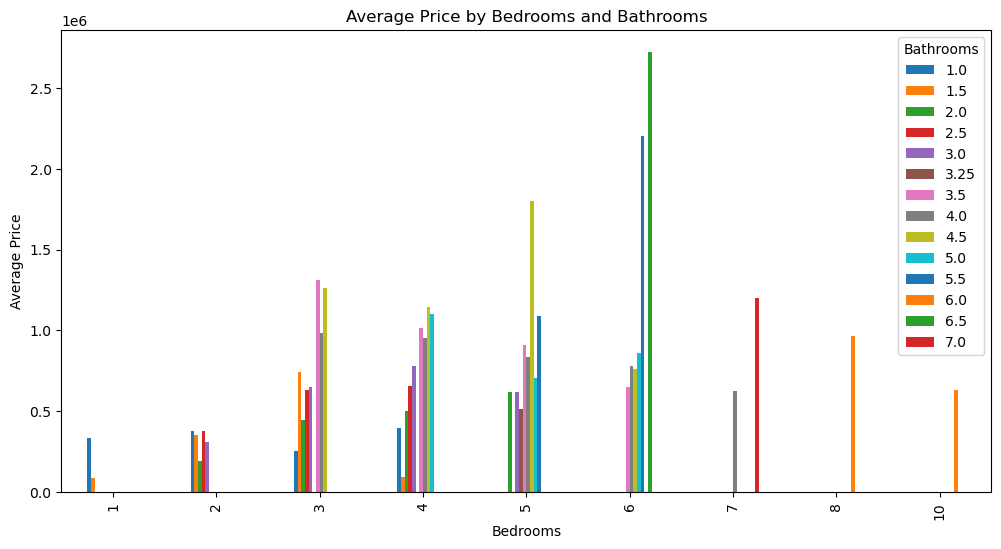

In [ ]:
grouped = train_data.groupby(['Bedrooms', 'Bathrooms'])['Price'].mean().unstack()

grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Average Price by Bedrooms and Bathrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Average Price')
plt.show()

Grouped bar chart to check a relation between combinations of bedroom and bathroom amounts (looks really weird due to there being half and quarters)

### 1.4 Conclusions Distribution

In the graphs above, we visualized the distribution of values. We do this to check for outliers and correlations. It also allows us to understand the shape of the data and whether it is complete, ensuring there are no missing values.

When looking at the graphs, we can draw certain conclusions. The first one is that as the area increases, the number of houses decreases. Additionally, as prices rise, the number of houses also declines.

We also noticed several outliers in the 'price' column. This can be explained by some houses having significantly higher prices than the average. In the end, we will leave these outliers in the dataset, as they could positively impact the accuracy of price predictions.

It is also clear that house prices rise relative to the number of bedrooms and bathrooms per home. However, in the dataset, there are also half and quarter bathrooms. We found that these exist but have different interiors. A full bathroom (1) includes a shower/bath, toilet, and sink. A half bathroom (0.5) includes only a toilet and sink. A quarter bathroom (0.25) contains only a sink. This explains the unusual values in the bathroom column.

### 1.5 Correlations between variables

In this chapter, we'll look at the underlying relationships between variables, establishing whether there are positive or negative correlations between them.

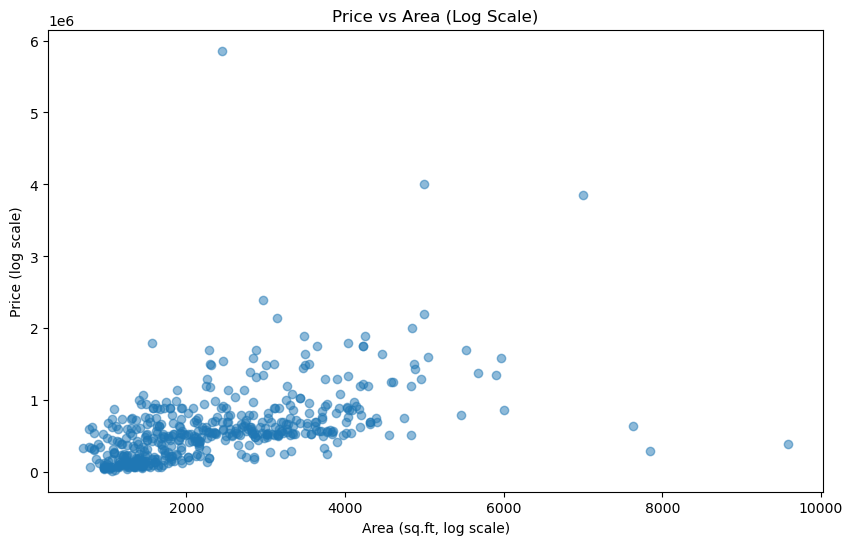

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['Area'], train_data['Price'], alpha=0.5)
#plt.xscale('log')
#plt.yscale('log')
plt.title('Price vs Area (Log Scale)')
plt.xlabel('Area (sq.ft, log scale)')
plt.ylabel('Price (log scale)')
plt.show()

Since both price and area are skewed we can check for non linear trend using a log scaling scatter plot. There is a slight linear relationship between the 'Area in square feet' and 'Price' columns.

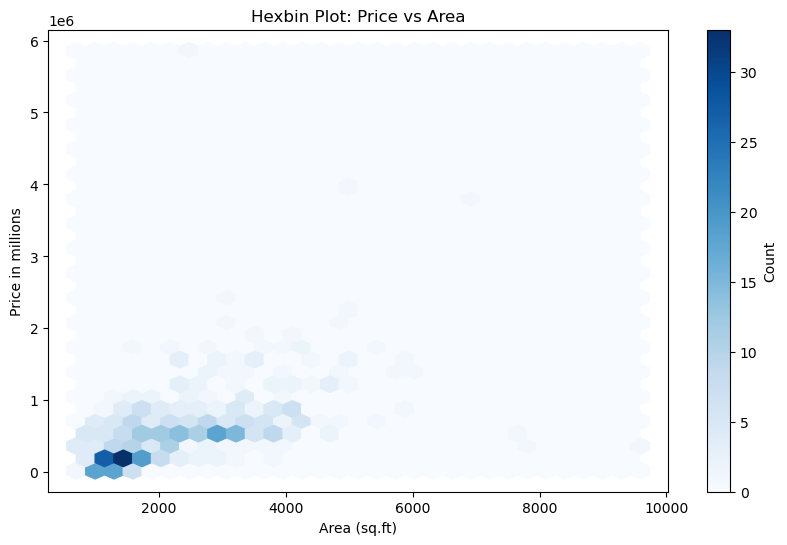

In [ ]:
plt.figure(figsize=(10, 6))
plt.hexbin(train_data['Area'], train_data['Price'], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Hexbin Plot: Price vs Area')
plt.xlabel('Area (sq.ft)')
plt.ylabel('Price in millions')
plt.show()

A hexbin plot shows us where the most bins overlap; the darker the color, the more data points are in the bin. It therefore indicates where you have the most data/information.

### 1.6 Correlations conclusions

From the above visualizations, it is clear that there is a slight linear relationship between 'Price' and 'Area in square feet.' In the earlier chapter on Distribution, we already observed trends between other variables, such as price increasing relative to the number of bedrooms and bathrooms.

Additionally, the number of houses decreases as prices rise and as the area increases. This could be considered a negative correlation. These are the most valuable conclusions drawn from the correlation analysis.

### 1.7 latitude, longitude research


#### 1.7.1 Is the latitude, longtitude exact or per neighbourhood?

In [ ]:
train_data['LatLong'] = train_data['Latitude'] + train_data['Longitude']
train_data['LatLong'].nunique()

47

It looks to be per neighbourhood as there are only 47 unique combinations.

#### 1.7.2 Location Heatmap

In [ ]:
#base map centered on the mean latitude/longitude
map_center = [train_data['Latitude'].mean(), train_data['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=5)

# Adds bubbles for each house
for idx, row in train_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Price'] / train_data['Price'].max() * 10,  # Scale bubble size by price
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Price: ${row['Price']}"
    ).add_to(mymap)

mymap

Using a bubblemap we can quickly see where the house in our dataset are located and using the size we can see whats more expensive as well (gotta figure out how it calculates price to size)

#### 1.7.3 Location dispersion

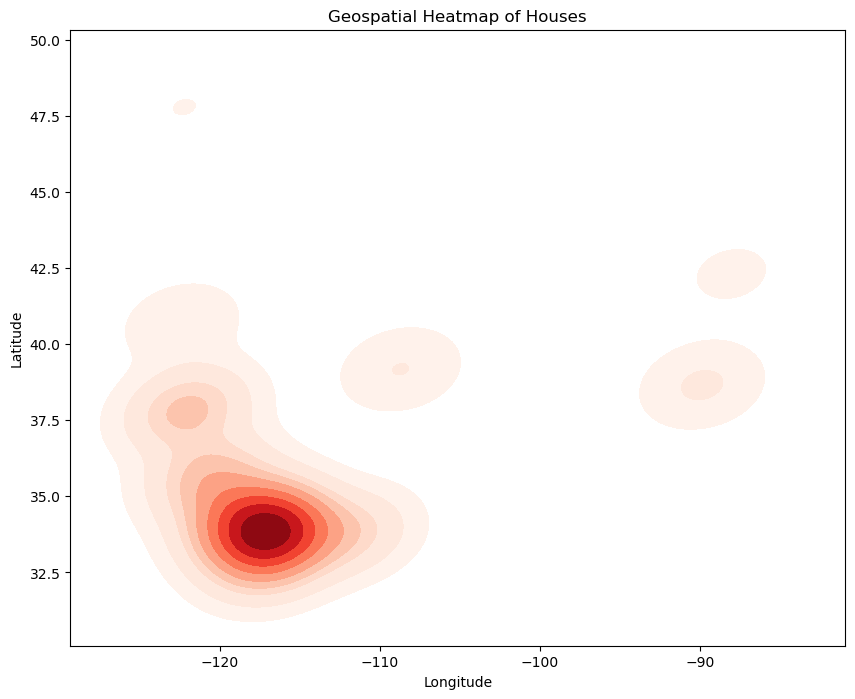

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(x=train_data['Longitude'], y=train_data['Latitude'], cmap='Reds', fill=True)
plt.title('Geospatial Heatmap of Houses')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Using a geospatial density heatmap we can quickly see where most of the house are located relative to eachother.

### 2 Feature Engineering

In [ ]:
# #Price per square foot
# train_data['Price_per_SqFt'] = train_data['Price'] / train_data['Area']
#
# #Bedroom to bathroom ratio
# train_data['Bedroom_Bathroom_Ratio'] = train_data['Bedrooms'].astype(float) / train_data['Bathrooms'].astype(float)
#
# #Total rooms in the house
# train_data['Total_Rooms'] = train_data['Bedrooms'] + train_data['Bathrooms']
#
# #Interaction between bedrooms and bathrooms
# train_data['Bedrooms_x_Bathrooms'] = train_data['Bedrooms'] * train_data['Bathrooms']

Clustering the neighbourhoods and calculating avg price and how many houses are in it, we can use this to make new features (neighbourood size might not be usefull)

In [ ]:

# coords = train_data[['Latitude', 'Longitude']]
# kmeans = KMeans(n_clusters=10, random_state=42)  # might need to adjust clusters still
# train_data['Neighborhood_Cluster'] = kmeans.fit_predict(coords)
#
# train_data['Neighborhood_Avg_Price'] = train_data.groupby('Neighborhood_Cluster')['Price'].transform('mean')
#
# train_data['Neighborhood_Size'] = train_data.groupby('Neighborhood_Cluster')['Price'].transform('count')

Visualizing new features

Seeing the relationship in price vs price per square feet

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price_per_SqFt', y='Price', data=train_data, alpha=0.6)
plt.title('Price vs Price per Sq.Ft')
plt.xlabel('Price per Sq.Ft')
plt.ylabel('Price')
plt.show()

ValueError: Could not interpret value `Price_per_SqFt` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In this scatter plot, it can be seen that more expensive houses also have a higher price per square foot. There is therefore a positive correlation between these two columns.


Gotta fix the x axis. Shows the relation in the different combinations of bedroom bathroom ratios

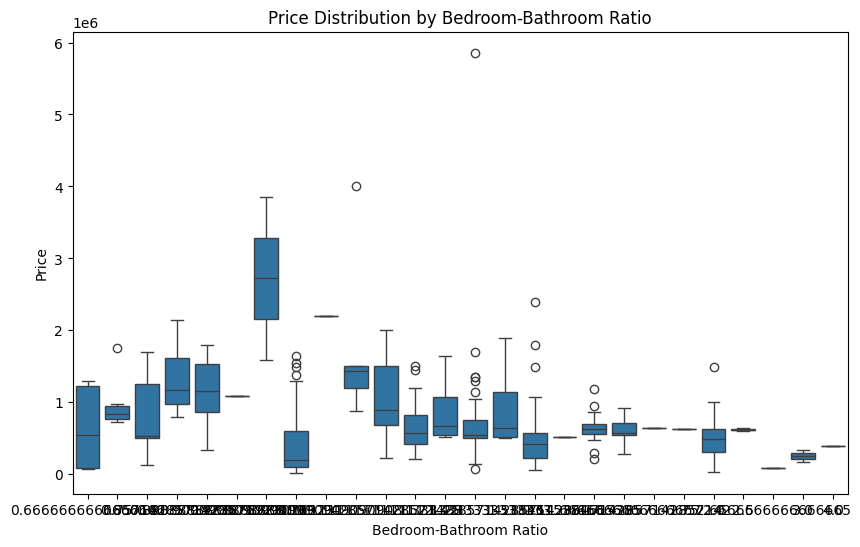

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bedroom_Bathroom_Ratio', y='Price', data=train_data)
plt.title('Price Distribution by Bedroom-Bathroom Ratio')
plt.xlabel('Bedroom-Bathroom Ratio')
plt.ylabel('Price')
plt.show()

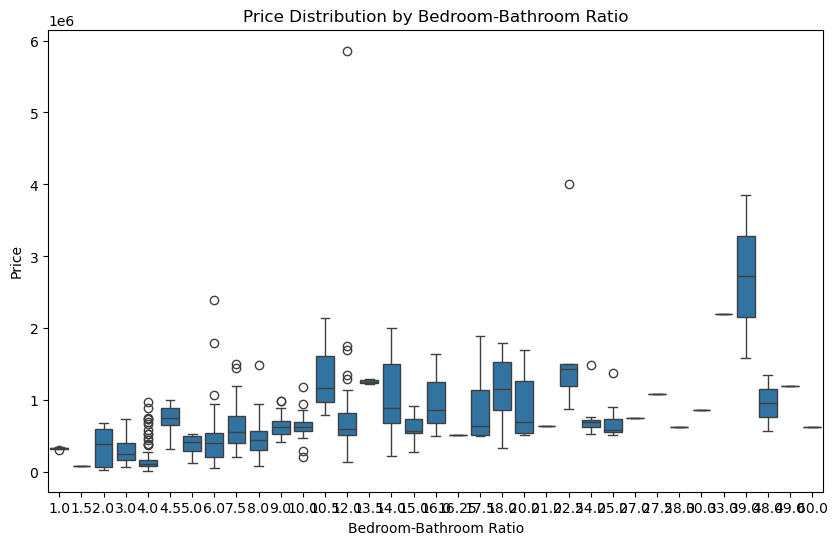

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bedrooms_x_Bathrooms', y='Price', data=train_data)
plt.title('Price Distribution by Bedroom-Bathroom Ratio')
plt.xlabel('Bedroom-Bathroom Ratio')
plt.ylabel('Price')
plt.show()

We can check if the neighbourhoods actually impact the price (might need some adjustment in amount of clusters)

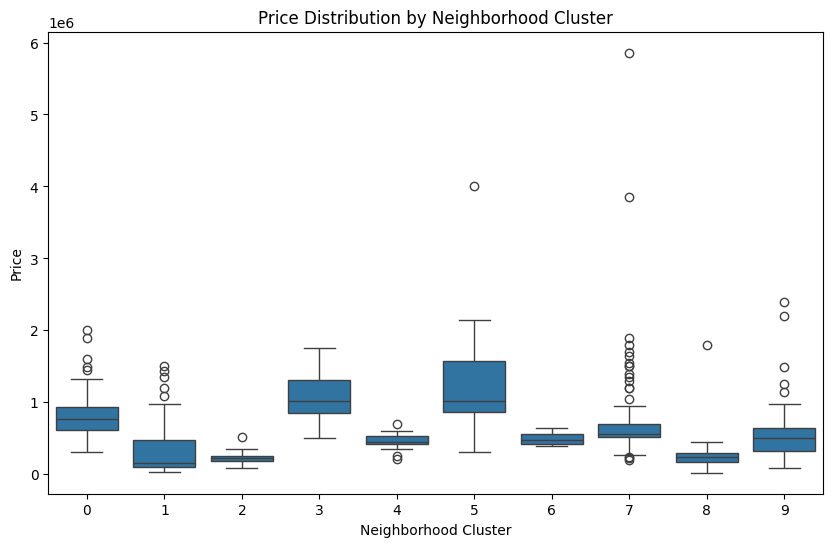

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Neighborhood_Cluster', y='Price', data=train_data)
plt.title('Price Distribution by Neighborhood Cluster')
plt.xlabel('Neighborhood Cluster')
plt.ylabel('Price')
plt.show()

Visualizing the price distribution in different amount of total rooms

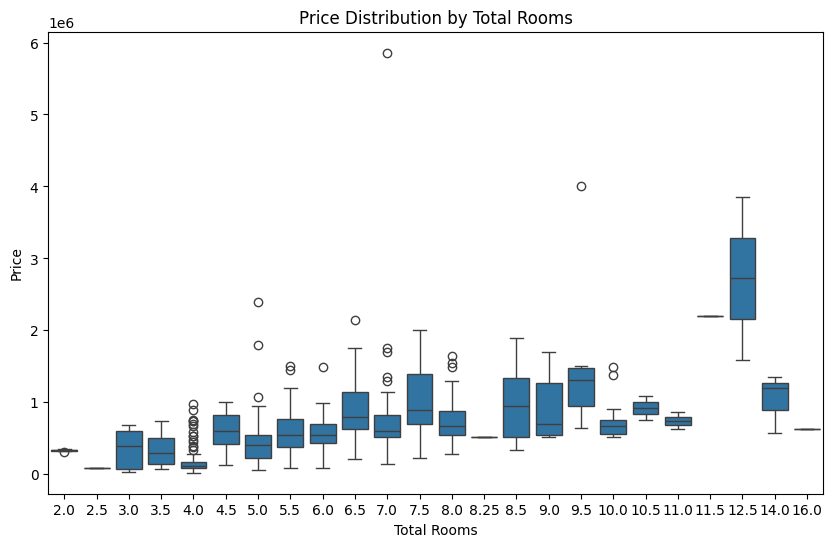

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Total_Rooms', y='Price', data=train_data)
plt.title('Price Distribution by Total Rooms')
plt.xlabel('Total Rooms')
plt.ylabel('Price')
plt.show()

To do preprocessing:
- check if log transform needs to be done on price and area since they are heavily skewed
- check if we need to one-hot encode bedrooms and bathrooms since they are categorical

## Opdracht 2: Fully-connected neuraal netwerk

In [ ]:
display(train_data.head(5))
display(test_data.head(5))

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


### 2.1 Train-test split

In [ ]:
# Train-test split
X = train_data.drop(['House ID', 'Price'], axis=1)
y = train_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2.2 Scaling the data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A StandardScaler is applied to the dataset to ensure that no features dominate others due to large values. This helps the model perform more consistently and reduces instability.

### 2.3 Hyperparameter tuning

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Deciding the amounto of hidden layers
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=7, step=1)

    # Add an amount of hidden layers with the amount of units and activation function
    for i in range(num_hidden_layers):
        units = hp.Int(f'units_{i}', min_value=1, max_value=128, step=1)
        activation = hp.Choice(f'activation_{i}', values=['relu'])

        # Regularisatie: kies tussen 'none', 'l1' of 'l2'
        reg_type = hp.Choice(f'reg_type_{i}', values=['none', 'l1', 'l2'])
        if reg_type == 'l1':
            reg = regularizers.l1(hp.Float(f'l1_{i}', 1e-5, 1e-2, sampling='log'))
        elif reg_type == 'l2':
            reg = regularizers.l2(hp.Float(f'l2_{i}', 1e-5, 1e-2, sampling='log'))
        else:
            reg = None

        # Voeg de Dense-laag toe, met kernel_regularizer als reg niet None is
        if i == 0:
            model.add(layers.Dense(units=units,
                                   activation=activation,
                                   kernel_regularizer=reg,
                                   input_shape=(5,)))
        else:
            model.add(layers.Dense(units=units,
                                   activation=activation,
                                   kernel_regularizer=reg))

        # Add a optional batch normalization layer
        if hp.Boolean(f'batchnorm_{i}'):
            model.add(layers.BatchNormalization())

        # Add a optional dropout layer with a dropout rate between 0 and 0.5
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Add a output layer with 1 unit and a relu activation function
    model.add(layers.Dense(1, activation='relu'))

    # Add a optimizer with a choice between adam and rmsprop
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    # Compile the model with a mean absolute percentage error loss function
    model.compile(optimizer=optimizer, loss='mape')
    return model

# Random search for hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',      # Doel: minimaliseer de val_loss
    max_trials=255,             # Aantal te proberen willekeurige hyperparametercombinaties
    directory='my_new_dir',    # Directory waarin resultaten worden opgeslagen
    project_name='keras_tuner_random_search_demo'
)

# Search for the best hyperparameters and train the model for 200 epochs with a validation split of 0.2
tuner.search(X_train_scaled, y_train, epochs=200, validation_split=0.2)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Beste hyperparameters:", best_hp.values)

Trial 255 Complete [00h 00m 14s]
val_loss: 99.99503326416016

Best val_loss So Far: 36.78892135620117
Total elapsed time: 2d 04h 37m 30s
Beste hyperparameters: {'num_hidden_layers': 5, 'units_0': 72, 'activation_0': 'relu', 'optimizer': 'rmsprop', 'units_1': 71, 'activation_1': 'relu', 'units_2': 126, 'activation_2': 'relu', 'units_3': 50, 'activation_3': 'relu', 'units_4': 43, 'activation_4': 'relu', 'units_5': 101, 'activation_5': 'sigmoid', 'units_6': 128, 'activation_6': 'tanh', 'reg_type_0': 'none', 'batchnorm_0': False, 'dropout_0': 0.0, 'reg_type_1': 'none', 'batchnorm_1': False, 'dropout_1': 0.0, 'reg_type_2': 'none', 'batchnorm_2': False, 'dropout_2': 0.0, 'reg_type_3': 'none', 'batchnorm_3': False, 'dropout_3': 0.0, 'reg_type_4': 'none', 'batchnorm_4': False, 'dropout_4': 0.0}


c:\Users\jesse\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 2.4 Create a neural network model

In [ ]:
model = keras.Sequential([
    layers.Dense(72, activation='relu', input_shape=(5,)),
    layers.Dense(71, activation='relu'),
    layers.Dense(126, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(43, activation='relu'),
    layers.Dense(1, activation='relu')
  ])

c:\Users\jesse\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The number of layers and the number of neurons per layer were determined using the random search method. Random search was chosen as it provided a more efficient way to train the model.

In the random search, only the 'ReLU' activation function was used to tune the model's hyperparameters. This choice was made because we are dealing with a regression task. ReLU is more suitable in this case, as sigmoid and tanh are primarily used for classification problems.

In [ ]:
# Compile the model
model.compile(
    optimizer='rmsprop',
    loss='mape'
)

The Adam and RMSprop optimizers were included in the random search. The search results showed that the RMSprop optimizer achieved the best score, which is why it was selected for the neural network. RMSprop adjusts the learning rate for each parameter individually, allowing it to handle features with different scales more effectively. Even though the dataset was scaled beforehand, this could still be a reason why it performed better for our model.

The loss function used is Mean Absolute Percentage Error (MAPE). It calculates the average percentage error between the actual and predicted values. This loss function was assigned for this task, which is why it is used to evaluate the model.

### 2.5 Model architecture

In [ ]:
# Model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 72)             │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 71)             │         5,183 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 126)            │         9,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │         6,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 43)             │         2,193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,274 (90.91 KB)

 Trainable params: 23,274 (90.91 KB)

 Non-trainable params: 0 (0.00 B)

**Plot_model nog gebruiken**

### 2.6 Training the model

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=250, validation_split=0.2)


Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 10/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 11/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 12/250
10/10 

### 2.7 Evaluating the model

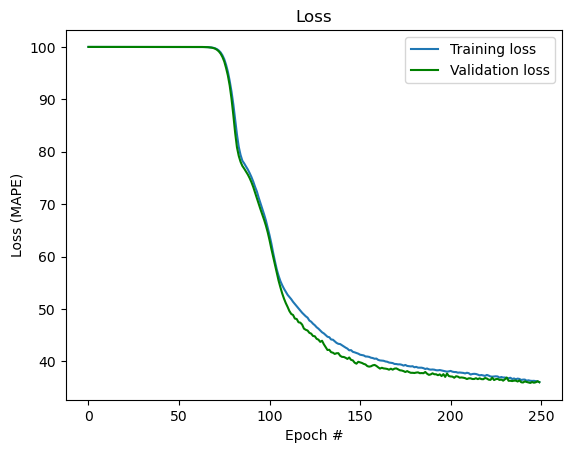

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss')
plt.legend()

In the graph above, it can be seen that as more epochs are used, the loss decreases significantly. This is particularly noticeable between 50 and 150 epochs, where the difference in loss increases substantially.

Around 220 epochs, the validation loss becomes higher than the training loss, indicating that the model is starting to overfit. This means the model is becoming too specialized in the training data and may not generalize well to unseen data.

As a result, the optimal number of epochs for our model is approximately 220 epochs.

In [ ]:
y_pred = model.predict(X_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
score = model.evaluate(X_test_scaled, y_test)
print(score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.3577 
32.70380783081055


The final Mean Absolute Percentage Error (MAPE) obtained from the model is 32.0768. This means that, on average, the difference between the predicted and actual values is approximately 32.

## Opdracht 3: Convolutional neural network from scratch

### Data loader


In [ ]:
display(train_data.head(5))

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


In [ ]:
train_data['House ID'] = train_data['House ID'].astype(str)

In [ ]:
from pathlib import Path

# Load images without considering the directory-generated labels
image_size = (1024, 1024)
batch_size = 10

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='Train/',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,  # Ignore directory-based labels
    shuffle=False   # Maintain a consistent order with file paths in the metadata
)

# Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_uuids = [Path(image_file_path).stem for image_file_path in image_file_paths]

# Map each file path to its label using the DataFrame
# Ensure the uuids in the DataFrame exactly match those in `image_uuids`
labels = [train_data.loc[train_data['House ID'] == uuid, 'Price'].values[0] for uuid in image_uuids]

# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

Found 500 files.


In [ ]:
# Split dataset into training and validation

train_dataset = final_dataset.take(10) # Use 25 batches for training
val_dataset = final_dataset.skip(10) # Use remaining batches for validation

In [ ]:
# Cache and prefetch for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = keras.layers.Rescaling(1./255, input_shape=(1024, 1024, 3))

c:\Users\jesse\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt

# Zorg ervoor dat de normalization_layer al is gedefinieerd met input_shape=(1024, 1024, 3)
# Voorbeeld:
# normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(1024, 1024, 3))

def build_cnn_model(hp):
    model = keras.Sequential()

    # Voeg de reeds gedefinieerde normalization_layer toe
    model.add(normalization_layer)

    # Voeg een variabel aantal Conv2D-lagen toe (bijv. 1 t/m 5 lagen)
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=5, step=1)
    for i in range(num_conv_layers):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
        activation = 'relu'

        # Kies tussen geen regularisatie, l1 of l2
        reg_type = hp.Choice(f'reg_type_{i}', values=['none', 'l1', 'l2'])
        if reg_type == 'l1':
            reg = regularizers.l1(hp.Float(f'l1_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        elif reg_type == 'l2':
            reg = regularizers.l2(hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        else:
            reg = None

        model.add(layers.Conv2D(filters=filters,
                                kernel_size=kernel_size,
                                activation=activation,
                                kernel_regularizer=reg))

        # Optioneel: voeg Batch Normalization toe
        if hp.Boolean(f'batchnorm_{i}'):
            model.add(layers.BatchNormalization())

        # Optioneel: voeg Dropout toe met een dropout rate tussen 0 en 0.5
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

        # Optioneel: voeg een MaxPooling2D-laag toe
        if hp.Boolean(f'maxpool_{i}'):
            model.add(layers.MaxPooling2D())

    # Flatten de output van de convolutionele lagen
    model.add(layers.Flatten())

    # Enkel één dense output-laag met 1 eenheid (geschikt voor een regressietaak)
    model.add(layers.Dense(1, activation='relu'))

    # Kies een optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    # Compileer het model met de MAPE loss functie
    model.compile(optimizer=optimizer, loss='mape')
    return model

# Stel de random search tuner in
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',      # Minimaliseer de validatie loss
    max_trials=5,            # Aantal te proberen hyperparametercombinaties
    directory='my_new_dir',    # Directory voor opslaan van de resultaten
    project_name='keras_tuner_random_search_cnn_regression'
)

# Zorg dat 'train_dataset' (een tf.data.Dataset) reeds is gedefinieerd en gebatcht
tuner.search(train_dataset, epochs=5)

# Haal het beste model en de bijbehorende hyperparameters op
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Beste hyperparameters:", best_hp.values)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_conv_layers
192               |192               |filters_0
3                 |3                 |kernel_size_0
none              |none              |reg_type_0
False             |False             |batchnorm_0
0.2               |0.2               |dropout_0
False             |False             |maxpool_0
rmsprop           |rmsprop           |optimizer

Epoch 1/5


In [ ]:
model = keras.Sequential([
            keras.Input(shape=(1024, 1024, 3)),
            normalization_layer,
            layers.Conv2D(4, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            Dropout(0.5),
            layers.Dense(1, activation='linear')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='mape',
    )

num_epochs = 10

history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 993ms/step - loss: 99.9970 - val_loss: 99.9339
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 848ms/step - loss: 99.9008 - val_loss: 98.8474
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 847ms/step - loss: 98.9744 - val_loss: 93.9632
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step - loss: 95.8380 - val_loss: 85.5313
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - loss: 92.4617 - val_loss: 72.0886
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 846ms/step - loss: 85.0617 - val_loss: 68.0746
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 848ms/step - loss: 74.7676 - val_loss: 83.2050
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 855ms/step - loss: 61.8950 - val_loss: 94.3528
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - loss: 57.7389 - val_loss: 109.0291
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 860ms/step - loss: 54.0692 - val_loss: 112.7797


# Downsampled test

In [ ]:
#cooking
import tensorflow as tf
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = (256, 256)  # Downsampled size
BATCH_SIZE = 32
SEED = 42


# Create list of all image paths
image_dir = Path('Train/')
image_paths = [str(p) for p in image_dir.glob('*.jpg')]  # Adjust extension if needed

# Create matching labels list using House ID from filenames
image_uuids = [Path(p).stem for p in image_paths]
labels = [train_data.loc[train_data['House ID'] == uuid, 'Price'].values[0]
           for uuid in image_uuids]

# Split into train/validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    random_state=SEED
)

# Create preprocessing function
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalization
    return img, label

# Create TensorFlow datasets
def create_dataset(paths, labels, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create final datasets
train_ds = create_dataset(train_paths, train_labels, shuffle=True)
val_ds = create_dataset(val_paths, val_labels)

# Optional: Verify dataset contents
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample label:", labels[0].numpy())

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Sample label: 379000


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

# Custom CNN architecture
model = tf.keras.Sequential([
    # Input and preprocessing
    layers.Input(shape=(256, 256, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    # Convolutional base
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),

    # Feature aggregation
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')
])

# Compile with optimized settings
optimizer = optimizers.Adam(
    learning_rate=0.001,
    clipvalue=1.0  # Gradient clipping
)
model.compile(
    loss='mape',
    optimizer=optimizer,
)

# Training callbacks
early_stopping = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    save_best_only=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - loss: 99.9998 - val_loss: 99.9992
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - loss: 99.9977 - val_loss: 99.9921
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - loss: 99.9786 - val_loss: 99.9447
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - loss: 99.8569 - val_loss: 99.7301
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - loss: 99.3918 - val_loss: 98.9593
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - loss: 97.7065 - val_loss: 96.6816
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - loss: 93.8719 - val_loss: 91.3685
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - loss: 85.1591 - val_loss: 81.1552
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - loss: 79.6451 - val_loss: 74.6306
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - loss: 66.5707 - val_loss: 72.5733
Epoch 12/200
13/13

KeyboardInterrupt: 

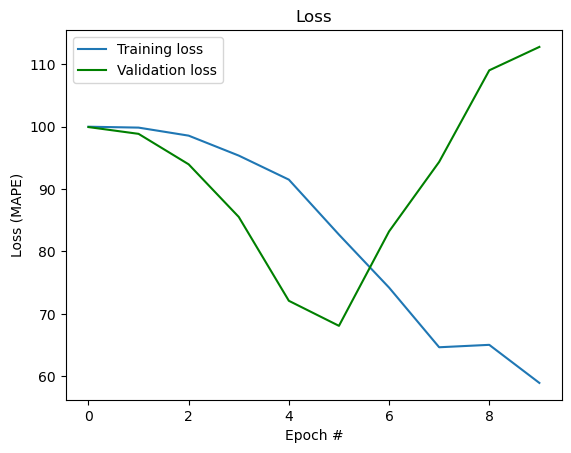

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss')
plt.legend()

In [ ]:
y_pred = model.predict(val_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step


In [ ]:
score = model.evaluate(val_dataset)
print(score)

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step - loss: 74.1809
74.73382568359375
